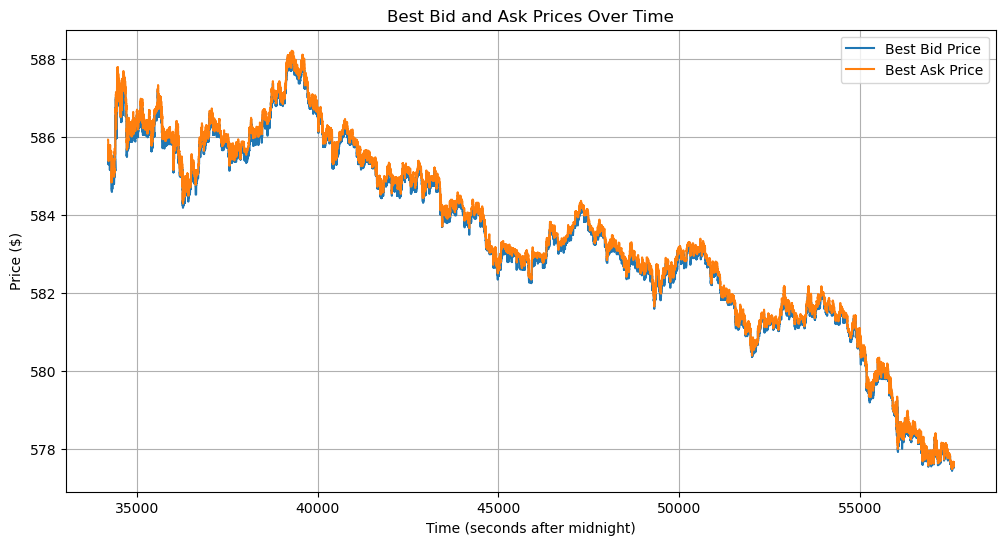

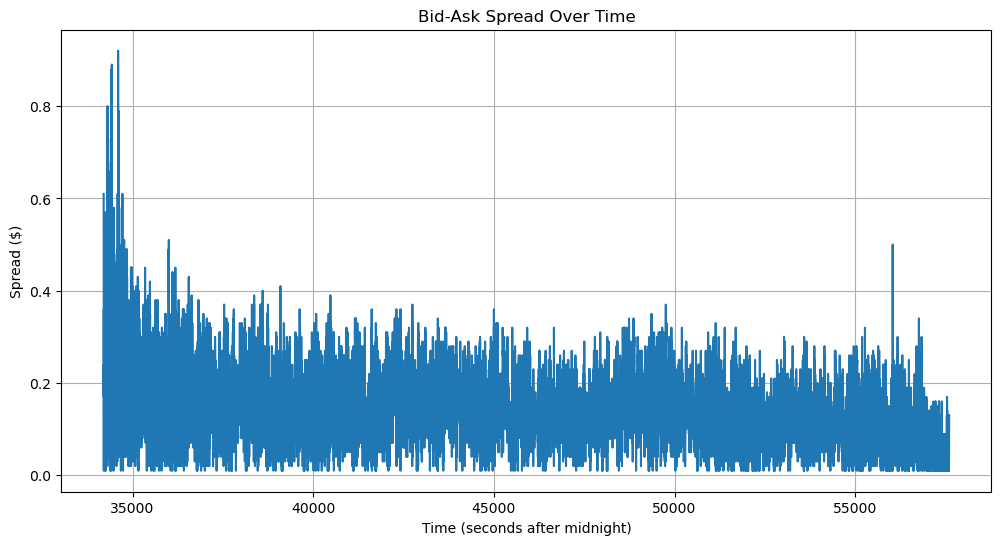

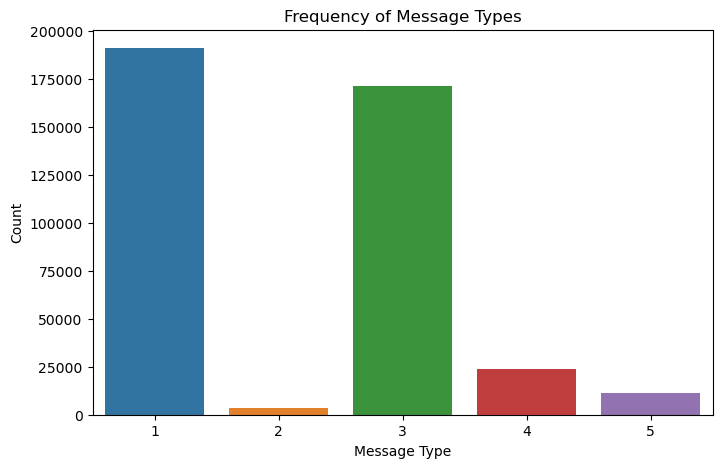

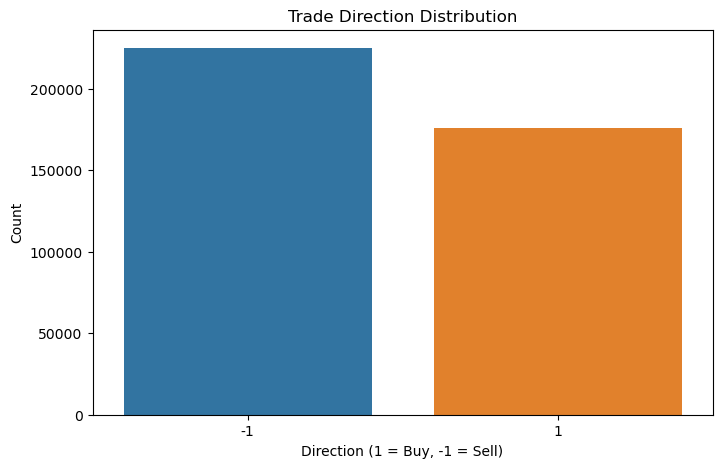

/var/folders/7g/vjpdqzx56rg24klzlm4flbsw0000gn/T/ipykernel_38338/2994021613.py:81: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  execution_ratio = execution_msgs["Type"].rolling(window=window_size).count() / window_size


Pearson correlation: -0.465, p-value: 0
T-statistic: 26.38, p-value: 2.8e-153


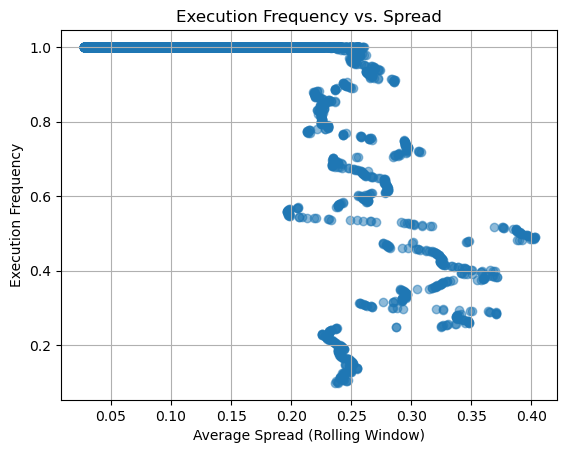

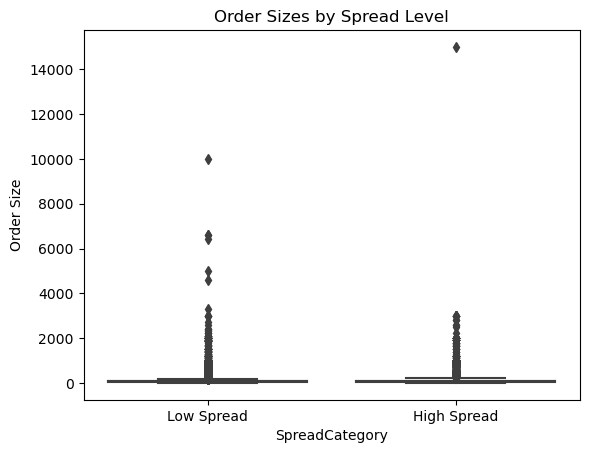

In [1]:
# Imports
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns

message_df = pd.read_csv("../data/raw/AAPL_2012-06-21_34200000_57600000_message_10.csv", header=None)
orderbook_df = pd.read_csv("../data/raw/AAPL_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)

message_df.columns = ["Time", "Type", "OrderID", "Size", "Price", "Direction"]




# Name columns in order book file
num_levels = int(orderbook_df.shape[1] / 4)
orderbook_cols = []
for level in range(1, num_levels + 1):
    orderbook_cols.extend([
        f"AskPrice{level}", f"AskSize{level}",
        f"BidPrice{level}", f"BidSize{level}"
    ])
orderbook_df.columns = orderbook_cols



plt.figure(figsize=(12,6))
plt.plot(message_df["Time"], orderbook_df["BidPrice1"] / 10000, label="Best Bid Price")
plt.plot(message_df["Time"], orderbook_df["AskPrice1"] / 10000, label="Best Ask Price")
plt.xlabel("Time (seconds after midnight)")
plt.ylabel("Price ($)")
plt.title("Best Bid and Ask Prices Over Time")
plt.legend()
plt.grid(True)
plt.show()



spread = (orderbook_df["AskPrice1"] - orderbook_df["BidPrice1"]) / 10000
plt.figure(figsize=(12,6))
plt.plot(message_df["Time"], spread)
plt.xlabel("Time (seconds after midnight)")
plt.ylabel("Spread ($)")
plt.title("Bid-Ask Spread Over Time")
plt.grid(True)
plt.show()




plt.figure(figsize=(8,5))
sns.countplot(x="Type", data=message_df)
plt.title("Frequency of Message Types")
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.show()


plt.figure(figsize=(8,5))
sns.countplot(x="Direction", data=message_df)
plt.title("Trade Direction Distribution")
plt.xlabel("Direction (1 = Buy, -1 = Sell)")
plt.ylabel("Count")
plt.show()

#Hypothesis 1
# Calculate spread in dollars
spread = (orderbook_df["AskPrice1"] - orderbook_df["BidPrice1"]) / 10000

# Filter execution messages (Type 4 = visible order executed)
execution_msgs = message_df[message_df["Type"] == 4].copy()

# Add spread value corresponding to each execution message (align by row index)
execution_msgs["Spread"] = spread.iloc[execution_msgs.index].values

# Calculate rolling average spread and rolling execution ratio
window_size = 1000
execution_ratio = execution_msgs["Type"].rolling(window=window_size).count() / window_size
mean_spread = spread.rolling(window=window_size).mean()

# Drop NaNs to align arrays for correlation
valid_idx = ~np.isnan(execution_ratio) & ~np.isnan(mean_spread)
execution_ratio_clean = execution_ratio[valid_idx]
mean_spread_clean = mean_spread[valid_idx]

# Run Pearson correlation test
corr_result = pearsonr(mean_spread_clean, execution_ratio_clean)
print(f"Pearson correlation: {corr_result[0]:.3f}, p-value: {corr_result[1]:.3g}")

#Hypothesis 2
# Use the median spread to split into low/high spread groups
threshold = spread.median()
low_spread_sizes = message_df.loc[spread < threshold, "Size"]
high_spread_sizes = message_df.loc[spread >= threshold, "Size"]

# Run t-test on order sizes
ttest_result = ttest_ind(low_spread_sizes, high_spread_sizes, equal_var=False)
print(f"T-statistic: {ttest_result.statistic:.2f}, p-value: {ttest_result.pvalue:.2g}")




#hypothesis 1
import matplotlib.pyplot as plt

plt.scatter(mean_spread_clean, execution_ratio_clean, alpha=0.5)
plt.xlabel("Average Spread (Rolling Window)")
plt.ylabel("Execution Frequency")
plt.title("Execution Frequency vs. Spread")
plt.grid(True)
plt.show()
#hypothesis 2
import seaborn as sns
import matplotlib.pyplot as plt

order_sizes = pd.DataFrame({
    "OrderSize": pd.concat([low_spread_sizes, high_spread_sizes], ignore_index=True),
    "SpreadCategory": ["Low Spread"] * len(low_spread_sizes) + ["High Spread"] * len(high_spread_sizes)
})

sns.boxplot(x="SpreadCategory", y="OrderSize", data=order_sizes)
plt.title("Order Sizes by Spread Level")
plt.ylabel("Order Size")
plt.show()







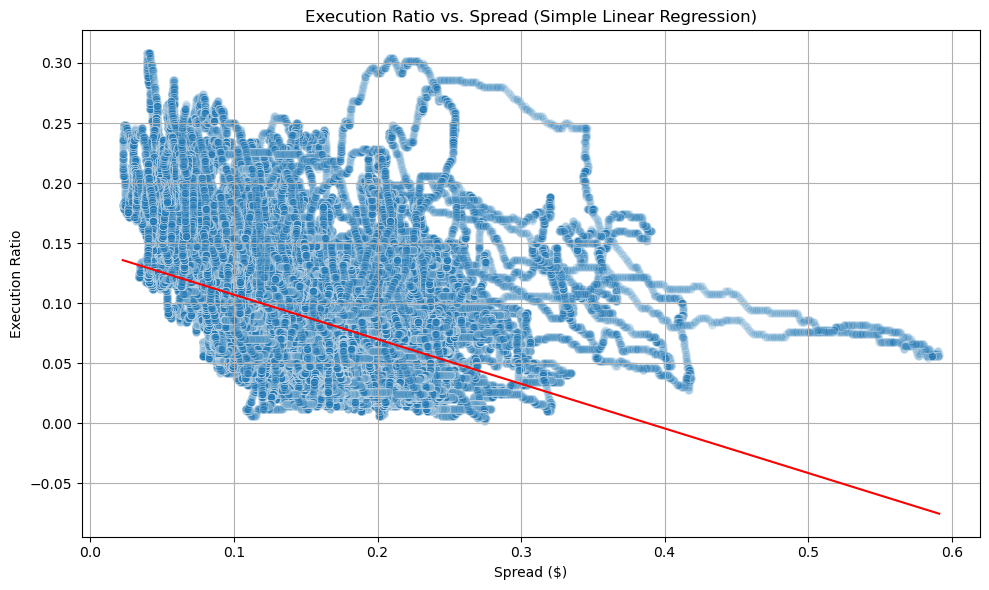

Simple Linear Regression: Execution Ratio ~ Spread
Coefficient: -0.37122438450808515
Intercept: 0.14416005788834688
R-squared: 0.17014008453823615

Multivariate Regression: Execution Ratio ~ Spread + Time of Day
Coefficients (Spread, Time of Day): [-0.39104852 -0.00071621]
Intercept: 0.1496065902068997
R-squared: 0.17074355123000118


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Calculate spread (in dollars)
spread = (orderbook_df["AskPrice1"] - orderbook_df["BidPrice1"]) / 10000.0

# Identify execution events (Types 4 and 5)
execution_mask = message_df["Type"].isin([4, 5])
execution_series = execution_mask.astype(int)

# Time of day (in hours since market open at 9:30am)
time_seconds = message_df["Time"]
time_of_day = (time_seconds - 34200) / 3600.0  # 34200 = 9:30am in seconds

# Rolling window
rolling_window = 500
execution_ratio = execution_series.rolling(rolling_window).mean()
spread_rolling = spread.rolling(rolling_window).mean()
time_rolling = time_of_day.rolling(rolling_window).mean()

# Test 1: Simple Linear Regression (Execution Ratio ~ Spread)

valid_idx_simple = (~execution_ratio.isna()) & (~spread_rolling.isna())
X_simple = spread_rolling[valid_idx_simple].values.reshape(-1, 1)
y_simple = execution_ratio[valid_idx_simple].values

model_simple = LinearRegression()
model_simple.fit(X_simple, y_simple)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_simple.flatten(), y=y_simple, alpha=0.2)
x_range = np.linspace(X_simple.min(), X_simple.max(), 100).reshape(-1, 1)
plt.plot(x_range, model_simple.predict(x_range), color='red')
plt.title("Execution Ratio vs. Spread (Simple Linear Regression)")
plt.xlabel("Spread ($)")
plt.ylabel("Execution Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Simple Linear Regression: Execution Ratio ~ Spread")
print("Coefficient:", model_simple.coef_[0])
print("Intercept:", model_simple.intercept_)
print("R-squared:", model_simple.score(X_simple, y_simple))

# Test 2: Multivariate Linear Regression (Execution Ratio ~ Spread + Time of Day)

valid_idx_multi = (~execution_ratio.isna()) & (~spread_rolling.isna()) & (~time_rolling.isna())
X_multi = np.vstack([
    spread_rolling[valid_idx_multi].values,
    time_rolling[valid_idx_multi].values
]).T
y_multi = execution_ratio[valid_idx_multi].values

model_multi = LinearRegression()
model_multi.fit(X_multi, y_multi)

print("\nMultivariate Regression: Execution Ratio ~ Spread + Time of Day")
print("Coefficients (Spread, Time of Day):", model_multi.coef_)
print("Intercept:", model_multi.intercept_)
print("R-squared:", model_multi.score(X_multi, y_multi))
